In [7]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import gc

In [8]:
def tensor_core_comparison_experiment(size=4096):
    """Compare CPU vs GPU performance to show tensor core effect"""

    results = []
    configs = [
        ('CPU FP32', 'cpu', torch.float32),
        ('GPU FP32', 'cuda', torch.float32),
        ('GPU FP16', 'cuda', torch.float16),
    ]

    for name, device, dtype in configs:
        print(f"{name}:")

        A = torch.randn(size, size, dtype=dtype, device=device)
        B = torch.randn(size, size, dtype=dtype, device=device)

        # Warmup
        warmup_runs = 5
        for _ in range(warmup_runs):
            _ = torch.matmul(A, B)
            if device == 'cuda':
                torch.cuda.synchronize()

        # Timing
        runs = 10
        times = []
        for _ in range(runs):
            if device == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            C = torch.matmul(A, B)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.perf_counter()
            times.append(end - start)

        # Metrics
        avg_time = np.mean(times)
        flops = 2 * size * size * size
        gflops = flops / (avg_time * 1e9)
        result = {
            'config': name,
            'device': device,
            'dtype': str(dtype),
            'gflops': gflops,
            'time_ms': avg_time * 1000
        }
        results.append(result)
        print(f"  {gflops:.1f} GFLOPS, {avg_time*1000:.0f}ms")

        # Clean up
        del A, B, C
        if device == 'cuda':
            torch.cuda.empty_cache()
    return pd.DataFrame(results)

def plot_tensor_core_comparison(df):
    """Plot CPU vs GPU tensor core comparison"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    bars = ax.bar(df['config'], df['gflops'], color=['gray', 'blue', 'orange'])
    ax.set_ylabel('Performance (GFLOPS)')
    ax.set_title('Activating Tensor Cores, CPU vs GPU Performance')
    ax.set_yscale('log')
    for bar, value in zip(bars, df['gflops']):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() * 1.1,
                f'{value:.0f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

CPU FP32:
  115.1 GFLOPS, 1194ms
GPU FP32:
  4246.9 GFLOPS, 32ms
GPU FP16:
  24911.2 GFLOPS, 6ms


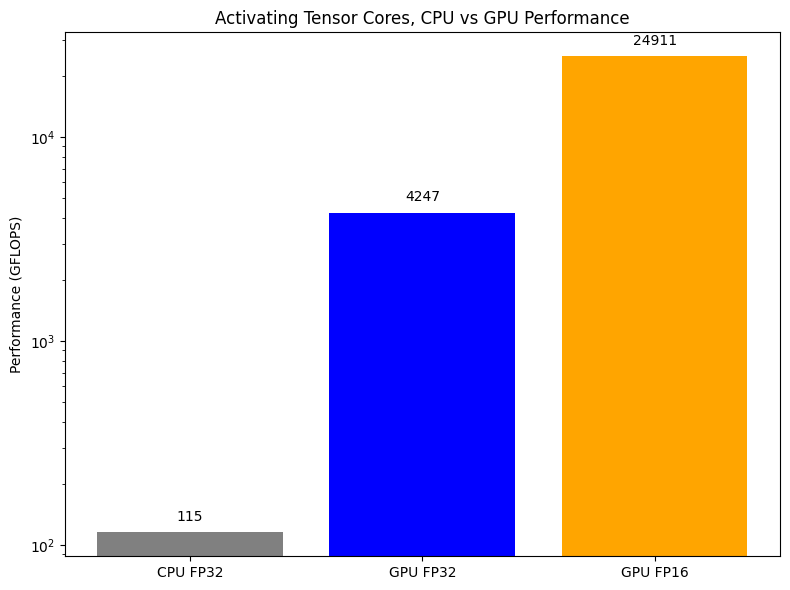

In [9]:
df_tensor = tensor_core_comparison_experiment(size=4096)
plot_tensor_core_comparison(df_tensor)